In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

In [8]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [11]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [14]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]

    return lang1, lang2

In [18]:
MAX_LENGTH = 40

In [19]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [20]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [21]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# 将数据集缓存到内存中以加快读取速度。
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [22]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [29]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [30]:
def scaled_dot_product_attention(q, k, v, mask):


    matmul_qk = tf.matmul(q, k, transpose_b=True)   
#     print(matmul_qk.shape)
    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
#     print(scaled_attention_logits.shape)
 
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

     
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # 
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [31]:
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# 这条 `请求（query）符合第二个`主键（key）`，
# 因此返回了第二个`数值（value）`。
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
scaled_dot_product_attention(temp_q, temp_k, temp_v,None)

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1.000000e+01, 9.276602e-25]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[8.4332744e-26, 1.0000000e+00, 8.4332744e-26, 8.4332744e-26]],
       dtype=float32)>)

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model =  d_model
        self.n_head = n_heads
        assert self.d_model%self.n_head == 0
        self.depth = d_model // self.n_head
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.n_head, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)   
        k = self.split_heads(k, batch_size)   
        v = self.split_heads(v, batch_size) 
#         print(q.shape)
#         print(k.shape)
#         print(v.shape)
#         print(q.shape)
        scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
#         print(scaled_attention.shape)
        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])
        concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))
#         print(scaled_attention.shape)
        output = self.dense(concat_attention)
        return output, attention_weights

In [33]:
temp_mha = MultiHeadAttention(d_model=512, n_heads=8)
y = tf.random.uniform((3,60, 512))  


In [34]:
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([3, 60, 512]), TensorShape([3, 8, 60, 60]))

In [35]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ]
    )

In [36]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_head, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, n_head)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, x, training, mask):
        multi_output, _ = self.mha(x,x,x,mask)
        drop_multi_output = self.dropout1(multi_output,training=training)
        add_norm = self.layernorm1(x + drop_multi_output)
        
        ffn_data = self.ffn(add_norm)
        drop_ffn_data= self.dropout2(ffn_data,training=training)
        out_put = self.layernorm2(add_norm + drop_ffn_data)
        
        return out_put
        

In [37]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((32,60,512)), False, None)
sample_encoder_layer_output.shape 

TensorShape([32, 60, 512])

In [38]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_head, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mask_mha = MultiHeadAttention(d_model, n_head)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.lay_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.mha = MultiHeadAttention(d_model, n_head)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.lay_norm2= tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        self.lay_norm3= tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        mask_out, attn_weights_block1 = self.mask_mha(x,x,x,look_ahead_mask)
        drop_mask_out = self.dropout1(mask_out, training=training)
        norm_drop_mask_out = self.lay_norm1(x+drop_mask_out)
        
        mha_out, attn_weights_block2 = self.mha(enc_output,enc_output,norm_drop_mask_out, padding_mask)
        drop_mha_out = self.dropout1(mha_out, training=training)
        norm_drop_mha_out = self.lay_norm1(norm_drop_mask_out+drop_mha_out)
        
        ffn_out = self.ffn(norm_drop_mha_out)
        drop_ffn_out = self.dropout3(ffn_out, training=training)
        norm_drop_ffn_out = self.lay_norm3(norm_drop_mha_out+drop_ffn_out)
        
        return norm_drop_ffn_out, attn_weights_block1, attn_weights_block2
    

        

In [40]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_layer_output,_,_= sample_decoder_layer(tf.random.uniform((32,60,512)),sample_encoder_layer_output,False, None, None)
sample_decoder_layer_output.shape 

TensorShape([32, 60, 512])

In [41]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def  call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x,training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

In [42]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), 
                                       training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [43]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [44]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer,  self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, 
                         dff, input_vocab_size,
                         pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
        
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights
        

In [45]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

In [46]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [48]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5,0,'Train Step')

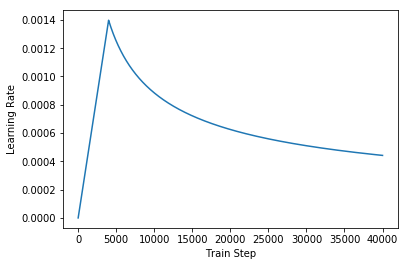

In [49]:
import matplotlib.pyplot as plt
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [50]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [51]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [52]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [53]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [65]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # 添加额外的维度来将填充加到
    # 注意力对数（logits）。
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [67]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [100]:
def create_masks(inp, tar):
    # 编码器填充遮挡
    enc_padding_mask = create_padding_mask(inp)

    # 在解码器的第二个注意力模块使用。
    # 该填充遮挡用于遮挡编码器的输出。
    dec_padding_mask = create_padding_mask(inp)

    # 在解码器的第一个注意力模块使用。
    # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
#     print(look_ahead_mask.shape)
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [101]:
a, b , c= create_masks(tf.random.uniform((60,512)), tf.random.uniform((55,512)))
print(a.shape)
print(b.shape)
print(c.shape)

(60, 1, 1, 512)
(55, 1, 512, 512)
(60, 1, 1, 512)


In [107]:
print(b[3][0])

tf.Tensor(
[[0. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(512, 512), dtype=float32)


In [69]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [70]:
EPOCHS = 20
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [72]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

    if batch % 1 == 0:
        print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

KeyboardInterrupt: 

In [75]:
for (batch, (inp, tar)) in enumerate(train_dataset):
    print(inp.shape)
    print(tar.shape)
    break

(64, 40)
(64, 39)


In [73]:
train_dataset

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>